# Analysis for salmon trap data in the Dungenesss River from 2005
### Description of data:
Data is stored in MS Excel files with one sheet per year. For 2005, the counts for both wild and hatchery are together with an additional column for wild fish. For all other years, counts for wild and hatchery fish are separate.



In [58]:
#imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from urllib.request import urlopen
from bs4 import BeautifulSoup
import io

In [60]:
# #read file in Windows
try:
    df_2005 = pd.read_excel(
   io="C:/Users/maria/OneDrive/Documents/data/pied_piper/Dungeness smolt trap 2005 - 2014.xlsx",
   sheet_name ='2005',
    header = [3,4]
)
except PermissionError:
    print("Permission Error. Close the file, if it is open.")
    

df_2005.head()
columns = list(df_2005)

In [406]:
#if using linux machine:
# df_2005 = pd.read_excel(
#    io="/home/maria/Documents/data/pied_piper/Dungeness smolt trap 2005 - 2014.xlsx",
#    sheet_name ='2005',
#     header = [3,4]
# )
# df_2005.head()
# df_2005.columns

MultiIndex([(                         'Unnamed: 0_level_0',  'Down'),
            (                         'Unnamed: 1_level_0',    'Up'),
            (                         'Unnamed: 2_level_0',    'In'),
            (                         'Unnamed: 3_level_0',   'Out'),
            (                                 'Chinook 0+',      10),
            (                                 'Chinook 1+',      11),
            (                                       'Chum',      20),
            (                                    'Coho 0+',      40),
            (                                   'Coho 1+ ',      41),
            (                                       'Pink',      30),
            (                                    'Sockeye',      50),
            (                                 'Trout parr',      65),
            (                           'Steelhead smolts',      71),
            (                           'Cutthroat smolts',      61),
            (       

In [61]:
df_2005.columns = df_2005.columns.droplevel(level=1)
df_2005.rename(columns = {
    'Unnamed: 0_level_0':'Down',
    'Unnamed: 1_level_0':'Up',
    'Unnamed: 2_level_0':'In',
    'Unnamed: 3_level_0':'Out',
    'Coho 1+ ':'Coho 1+'
}, inplace = True)

#making new columns
df_2005['Date'] = df_2005['Down'].dt.date
df_2005['midpoint'] = df_2005['Down'] + (df_2005['Up'] - df_2005['Down'])/2

#getting temperature data
#reading html data
year = '2005'
url = "https://apps.ecology.wa.gov/ContinuousFlowAndWQ/StationData/Prod/18A050/18A050_" + year + "_WTM_FM.TXT"
html = urlopen(url).read()
soup = BeautifulSoup(html, features="html.parser")

# kill all script and style elements
for script in soup(["script", "style"]):
    script.extract()    # rip it out

# get text
text = soup.get_text()

text = text[131:]

df = pd.read_csv(io.StringIO(text), sep='\s+', header = None, names = ["date", "time", "temp", "quality"])

df['midpoint'] =  pd.to_datetime(df['date'] + ' ' + df['time'])


df_2005_temp = pd.merge_asof(df_2005.dropna(subset = ['midpoint']),df, on="midpoint",tolerance=pd.Timedelta(minutes = 15))

# flow data 
url_flow = "https://apps.ecology.wa.gov/ContinuousFlowAndWQ/StationData/Prod/18A050/18A050_" + year+ "_DSG_FM.TXT"
html_flow = urlopen(url_flow).read()
soup_flow = BeautifulSoup(html_flow, features="html.parser")

# kill all script and style elements
for script in soup_flow(["script", "style"]):
    script.extract()    # rip it out

# get text
text_flow = soup_flow.get_text()
text_flow = text_flow[119:]

df_flow = pd.read_csv(io.StringIO(text_flow), sep='\s+', header = None, names = ["date", "time", "flow", "quality"])

df_flow['midpoint'] =  pd.to_datetime(df_flow['date'] + ' ' + df_flow['time'])

df_2005_temp_flow = pd.merge_asof(
    df_2005_temp.dropna(subset = ['midpoint']),df_flow, on="midpoint",tolerance=pd.Timedelta(minutes = 15))

#aggregating the data
groupedby_dates_2005 = df_2005_temp_flow.groupby(by=["Date"]).agg({'In':'sum',
                                       'Out':'sum',
                                       'Chinook 0+':'sum',
                                       'Chinook 1+':'sum',
                                       'Coho 0+':'sum',
                                       'Coho 1+':'sum',
                                       'Steelhead smolts':'sum',
                                       'Chinook 1+ CWT hatchery':'sum',
                                       'Coho 1+ UC mark Wild':'sum',
                                       'Coho 1+ LC mark Wild':'sum',
                                       'Coho 1+ Hatchery ad-mark':'sum',
                                       'Coho 1+ hatchery CWT not ad-marked':'sum',
                                       'Steelhead parr unmark wild':'sum',
                                       'Steelhead smolt UC mark wild':'sum',
                                       'Steelhead hatchery ad-mark':'sum',
                                       'Steelhead adult unmark wild':'sum',
                                       'temp':'mean',
                                       'flow':'mean'})
groupedby_dates_2005 = groupedby_dates_2005[groupedby_dates_2005['Out'] == 0]
groupedby_dates_2005.fillna(0)


,In,Out,Chinook 0+,Chinook 1+,Coho 0+,Coho 1+,Steelhead smolts,Chinook 1+ CWT hatchery,Coho 1+ UC mark Wild,Coho 1+ LC mark Wild,Coho 1+ Hatchery ad-mark,Coho 1+ hatchery CWT not ad-marked,Steelhead parr unmark wild,Steelhead smolt UC mark wild,Steelhead hatchery ad-mark,Steelhead adult unmark wild,temp,flow
Date,,,,,,,,,,,,,,,,,,
2005-03-08,19.733333,0.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7.000000,154.000000
2005-03-10,23.300000,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7.200000,175.000000
2005-03-11,24.266667,0.0,119.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.333333,169.333333
2005-03-12,22.866667,0.0,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7.150000,168.000000
2005-03-13,24.466667,0.0,127.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.450000,158.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-07-19,24.000000,0.0,30.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.050000,124.000000
2005-07-22,23.500000,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.900000,112.000000
2005-07-28,23.833333,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,14.100000,81.200000


In [62]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(groupedby_dates_2005)

,In,Out,Chinook 0+,Chinook 1+,Coho 0+,Coho 1+,Steelhead smolts,Chinook 1+ CWT hatchery,Coho 1+ UC mark Wild,Coho 1+ LC mark Wild,Coho 1+ Hatchery ad-mark,Coho 1+ hatchery CWT not ad-marked,Steelhead parr unmark wild,Steelhead smolt UC mark wild,Steelhead hatchery ad-mark,Steelhead adult unmark wild,temp,flow
Date,,,,,,,,,,,,,,,,,,
2005-03-08,19.733333,0.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7.000000,154.000000
2005-03-10,23.300000,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7.200000,175.000000
2005-03-11,24.266667,0.0,119.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.333333,169.333333
2005-03-12,22.866667,0.0,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7.150000,168.000000
2005-03-13,24.466667,0.0,127.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.450000,158.500000
2005-03-14,24.416667,0.0,162.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.650000,151.500000
2005-03-15,22.900000,0.0,47.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7.200000,145.333333
2005-03-16,24.366667,0.0,205.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.200000,149.500000
2005-03-17,24.450000,0.0,175.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,6.650000,142.000000


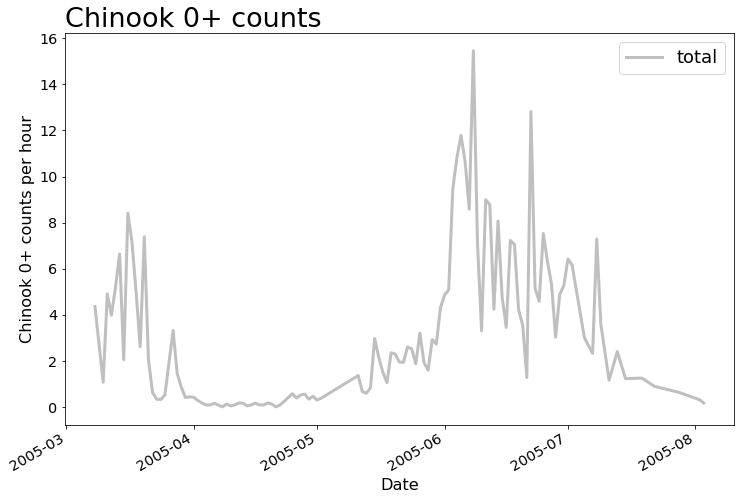

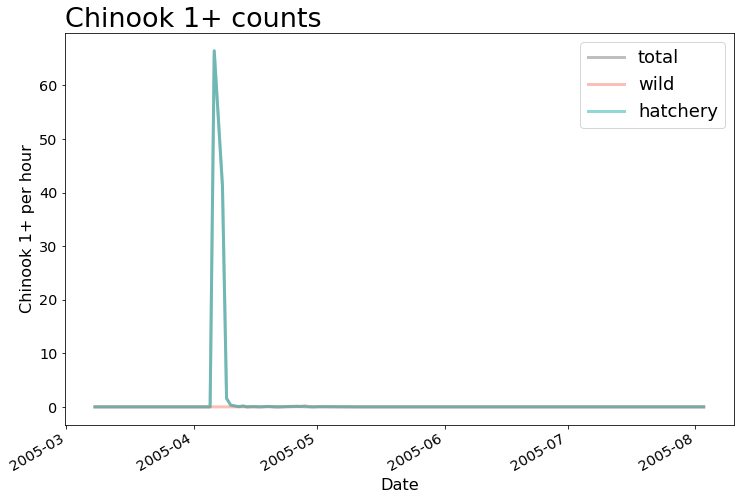

In [64]:
#Chinook 
groupedby_dates_2005['chinook1_perhour'] = groupedby_dates_2005['Chinook 1+']/groupedby_dates_2005['In']
groupedby_dates_2005['chinook1_hatchery_perhour'] = groupedby_dates_2005['Chinook 1+ CWT hatchery']/groupedby_dates_2005['In']
groupedby_dates_2005['chinook1_wild_perhour'] = groupedby_dates_2005['chinook1_perhour'] - groupedby_dates_2005['chinook1_hatchery_perhour']

#chinook 0
groupedby_dates_2005['chinook0_perhour'] = groupedby_dates_2005['Chinook 0+']/groupedby_dates_2005['In']



fs = 18
lw = 3
transparency = 0.5
plt.close('all') # always start by cleaning up
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(111)
ax1.plot(
    groupedby_dates_2005.index, groupedby_dates_2005['chinook0_perhour'], color = 'gray',
    label = 'total', alpha = 0.5, linewidth = lw)
plt.gcf().autofmt_xdate()
plt.xlabel('Date', size = 0.9*fs)
plt.ylabel('Chinook 0+ counts per hour', size = 0.9*fs)
ax1.tick_params(labelsize=.8*fs)
ax1.set_title('Chinook 0+ counts', loc='left', fontsize = fs*1.5)
plt.legend(fontsize=fs, loc='upper right', title = '')

plt.show()


#chinook1
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(
    groupedby_dates_2005.index, groupedby_dates_2005['chinook1_perhour'], 
    linewidth = 3, label = 'total', color = 'gray', alpha = transparency)
ax.plot(
    groupedby_dates_2005.index, groupedby_dates_2005['chinook1_wild_perhour'], 
    linewidth = 3, label = 'wild', color = 'salmon', alpha = transparency)

ax.plot(
    groupedby_dates_2005.index, groupedby_dates_2005['chinook1_hatchery_perhour'], 
    linewidth = 3, label  = 'hatchery', color = 'lightseagreen', alpha = transparency)

plt.gcf().autofmt_xdate()
plt.xlabel('Date', size = 0.9*fs)
plt.ylabel('Chinook 1+ per hour', size = 0.9*fs)
ax.tick_params(labelsize=.8*fs)
ax.set_title('Chinook 1+ counts', loc='left', fontsize = fs*1.5)
plt.legend(fontsize=fs, loc='upper right', title = '')


plt.show()


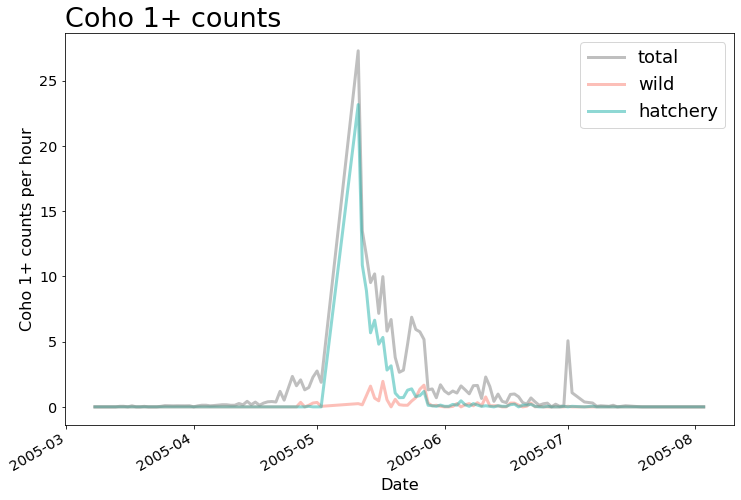

In [65]:
#Coho
groupedby_dates_2005['coho1_perhour'] = groupedby_dates_2005['Coho 1+']/groupedby_dates_2005['In']

groupedby_dates_2005['Coho 1+ UC mark Wild per hour'] = (
    groupedby_dates_2005['Coho 1+ UC mark Wild']/groupedby_dates_2005['In'])

groupedby_dates_2005['Coho 1+ LC mark Wild per hour'] = (
    groupedby_dates_2005['Coho 1+ LC mark Wild']/groupedby_dates_2005['In'])

groupedby_dates_2005['coho1_wild_perhour'] = (
    groupedby_dates_2005['Coho 1+ UC mark Wild per hour'] + groupedby_dates_2005['Coho 1+ LC mark Wild per hour'])

groupedby_dates_2005['Coho 1+ Hatchery ad-mark per hour'] = (
    groupedby_dates_2005['Coho 1+ Hatchery ad-mark']/groupedby_dates_2005['In'])

groupedby_dates_2005['Coho 1+ hatchery CWT not ad-marked per hour'] = (
    groupedby_dates_2005['Coho 1+ hatchery CWT not ad-marked']/groupedby_dates_2005['In'])

groupedby_dates_2005['coho1_hatchery_perhour'] = (
    groupedby_dates_2005['Coho 1+ Hatchery ad-mark per hour'] + groupedby_dates_2005['Coho 1+ hatchery CWT not ad-marked per hour'])

lw = 3
plt.close('all') # always start by cleaning up
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(111)
ax1.plot(
    groupedby_dates_2005.index, groupedby_dates_2005['coho1_perhour'], color = 'gray', 
    label = 'total', alpha = 0.5, linewidth = lw)

ax1.plot(
    groupedby_dates_2005.index, groupedby_dates_2005['coho1_wild_perhour'], color = 'salmon', 
    label = 'wild', alpha = 0.5, linewidth = lw)


ax1.plot(groupedby_dates_2005.index, groupedby_dates_2005['coho1_hatchery_perhour'], color = 'lightseagreen', 
         label = 'hatchery', alpha = 0.5, linewidth = lw)

plt.gcf().autofmt_xdate()
plt.xlabel('Date', size = 0.9*fs)
plt.ylabel('Coho 1+ counts per hour', size = 0.9*fs)
ax1.tick_params(labelsize=.8*fs)
ax1.set_title('Coho 1+ counts', loc='left', fontsize = fs*1.5)
plt.legend(fontsize=fs, loc='upper right', title = '')

plt.show()


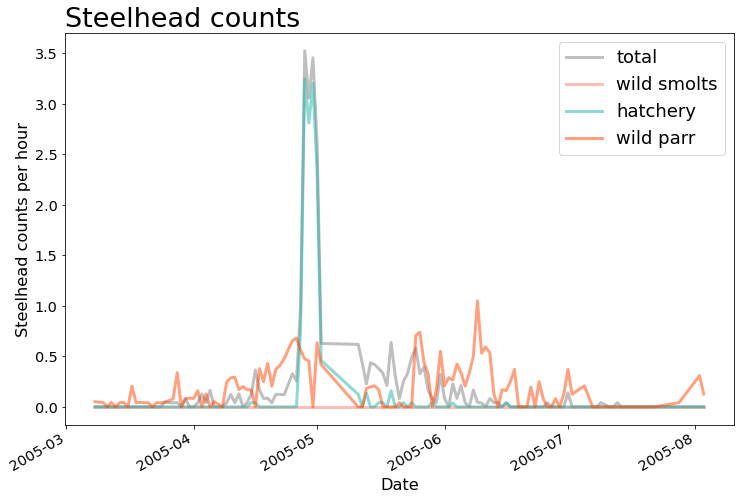

In [66]:
#Steelhead
groupedby_dates_2005['steelheadsmolt_perhour'] = (
    groupedby_dates_2005['Steelhead smolts']/groupedby_dates_2005['In'])

groupedby_dates_2005['steelheadsmolt_wild_perhour'] = (
    groupedby_dates_2005['Steelhead smolt UC mark wild']/groupedby_dates_2005['In'])

groupedby_dates_2005['steelhead_hatchery_perhour'] = (
    groupedby_dates_2005['Steelhead hatchery ad-mark']/groupedby_dates_2005['In'])

groupedby_dates_2005['steelheadparr_perhour'] = (
    groupedby_dates_2005['Steelhead parr unmark wild']/groupedby_dates_2005['In'])

fs = 18
lw = 3
transparency = 0.5
plt.close('all') # always start by cleaning up
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(111)
ax1.plot(
    groupedby_dates_2005.index, groupedby_dates_2005['steelheadsmolt_perhour'], color = 'gray', 
    label = 'total', alpha = 0.5, linewidth = lw)

ax1.plot(
    groupedby_dates_2005.index, groupedby_dates_2005['steelheadsmolt_wild_perhour'], color = 'salmon', 
    label = 'wild smolts', alpha = 0.5, linewidth = lw)


ax1.plot(groupedby_dates_2005.index, groupedby_dates_2005['steelhead_hatchery_perhour'], color = 'lightseagreen', 
         label = 'hatchery', alpha = 0.5, linewidth = lw)

ax1.plot(groupedby_dates_2005.index, groupedby_dates_2005['steelheadparr_perhour'], color = 'orangered', 
         label = 'wild parr', alpha = 0.5, linewidth = lw)

plt.gcf().autofmt_xdate()
plt.xlabel('Date', size = 0.9*fs)
plt.ylabel('Steelhead counts per hour', size = 0.9*fs)
ax1.tick_params(labelsize=.8*fs)
ax1.set_title('Steelhead counts', loc='left', fontsize = fs*1.5)
plt.legend(fontsize=fs, loc='upper right', title = '')

plt.show()

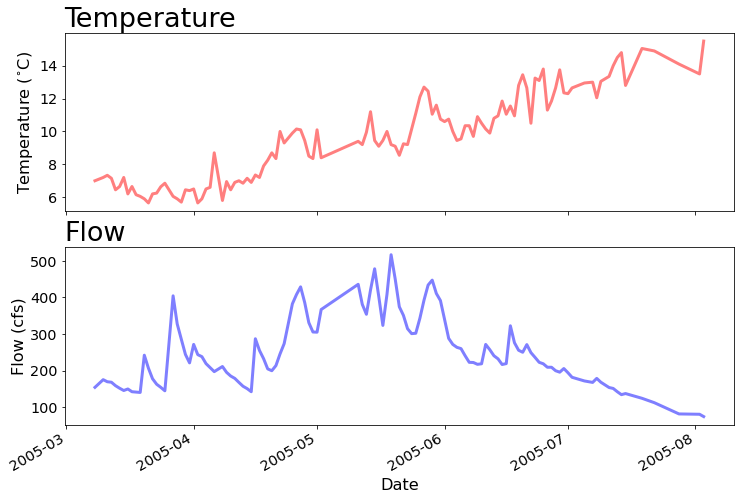

In [67]:
#plot temperature and flow
fs = 18
lw = 3
transparency = 0.5
plt.close('all') # always start by cleaning up
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
ax1.plot(
    groupedby_dates_2005.index, groupedby_dates_2005['temp'], color = 'red', 
    label = 'temperature', alpha = 0.5, linewidth = lw)
plt.gcf().autofmt_xdate()
plt.xlabel('Date', size = 0.9*fs)
plt.ylabel('Temperature '+ r'($^{\circ}$C)', size = 0.9*fs)
ax1.tick_params(labelsize=.8*fs)
ax1.set_title('Temperature', loc='left', fontsize = fs*1.5)
#plt.legend(fontsize=fs, loc='upper right', title = '')


#flow
ax2 = fig.add_subplot(212)
ax2.plot(
    groupedby_dates_2005.index, groupedby_dates_2005['flow'], color = 'blue', 
    label = 'flow', alpha = 0.5, linewidth = lw)
plt.gcf().autofmt_xdate()
plt.xlabel('Date', size = 0.9*fs)
plt.ylabel('Flow (cfs)', size = 0.9*fs)
ax2.tick_params(labelsize=.8*fs)
ax2.set_title('Flow', loc='left', fontsize = fs*1.5)
#plt.legend(fontsize=fs, loc='upper right', title = '')

plt.show()

In [68]:
#save datafram to csv in linux
# groupedby_dates_2005.to_csv('/home/maria/Documents/data/pied_piper/2005_dungeness.csv')  

#save datafram to csv in windows
groupedby_dates_2005.to_csv("C:/Users/maria/OneDrive/Documents/data/pied_piper/2005_dungeness.csv")  
